In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

# Data preprocessing

In [4]:
data = pd.read_csv('dataset_LUMINAL_A_B.csv')
data.head()

,l,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
0,Luminal A,2356.253792,26808.891103,57790.161586,0.0,71389.111749,381288.489078,0.0,1677.413295,1.969141e+06,...,113036.499486,0.0,20911.752405,13957.784680,1.047700e+06,0.0,1937.768563,10731.974977,0.0,0.0
1,Luminal A,0.000000,231.960840,115769.964478,0.0,77938.573803,238017.846096,0.0,0.000000,4.865670e+06,...,850405.301444,0.0,0.000000,2122.068451,0.000000e+00,0.0,5499.352680,2479.070667,0.0,0.0
2,Luminal A,0.000000,315.873536,44954.933833,0.0,58546.997851,249302.406604,0.0,270.107768,2.519212e+06,...,301948.579552,0.0,0.000000,481.622432,0.000000e+00,0.0,312.031830,4822.690978,0.0,0.0
3,Luminal A,1074.333108,0.000000,86991.783442,0.0,36082.381881,176274.146728,0.0,101.975469,2.855010e+06,...,293581.147891,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,12631.387770,0.0,0.0
4,Luminal A,1395.887715,0.000000,65199.337535,0.0,91469.201926,263704.398926,0.0,66.248682,4.235429e+06,...,350449.557585,0.0,0.000000,1181.263740,0.000000e+00,0.0,0.000000,1626.418477,0.0,0.0


In [5]:
data.shape

(100, 1023)

In [6]:
# prendo tutto il data tranne prima colonna

x = data.drop(data.columns[0], axis=1)
x.head()


,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
0,2356.253792,26808.891103,57790.161586,0.0,71389.111749,381288.489078,0.0,1677.413295,1.969141e+06,86793.265494,...,113036.499486,0.0,20911.752405,13957.784680,1.047700e+06,0.0,1937.768563,10731.974977,0.0,0.0
1,0.000000,231.960840,115769.964478,0.0,77938.573803,238017.846096,0.0,0.000000,4.865670e+06,769.742944,...,850405.301444,0.0,0.000000,2122.068451,0.000000e+00,0.0,5499.352680,2479.070667,0.0,0.0
2,0.000000,315.873536,44954.933833,0.0,58546.997851,249302.406604,0.0,270.107768,2.519212e+06,2620.500780,...,301948.579552,0.0,0.000000,481.622432,0.000000e+00,0.0,312.031830,4822.690978,0.0,0.0
3,1074.333108,0.000000,86991.783442,0.0,36082.381881,176274.146728,0.0,101.975469,2.855010e+06,9893.339903,...,293581.147891,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,12631.387770,0.0,0.0
4,1395.887715,0.000000,65199.337535,0.0,91469.201926,263704.398926,0.0,66.248682,4.235429e+06,2570.895661,...,350449.557585,0.0,0.000000,1181.263740,0.000000e+00,0.0,0.000000,1626.418477,0.0,0.0


In [7]:
x.shape

(100, 1022)

In [8]:
y = data['l']
y = pd.DataFrame(y)
y.head()

,l
0,Luminal A
1,Luminal A
2,Luminal A
3,Luminal A
4,Luminal A


In [9]:
import sklearn as sk

In [10]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
label_encoder.fit(y['l'])
y['l'] = label_encoder.transform(y['l'])
#vedere quante y sono 1 e quante 0
y.groupby('l').size()


l
0    50
1    50
dtype: int64

In [11]:
# da pandas a numpy
x = x.values
y = y.values

In [12]:
x.shape

(100, 1022)

In [13]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y)

In [14]:
# scaling the features with mean 0 and standard deviation 1
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scaler = MinMaxScaler()
# zeta score
scaler =  StandardScaler()

# scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)



In [15]:
from sklearn.decomposition import PCA  # Importa la classe PCA da scikit-learn
import numpy as np  # Importa la libreria NumPy per la manipolazione dei dati




# Crea un oggetto PCA e adatta i dati
pca = PCA()  # Crea un'istanza dell'oggetto PCA
pca.fit(x_train_scaled)    # Adatta i dati di input (X) all'oggetto PCA per eseguire l'analisi delle componenti principali

# Calcola gli autovalori e ordinali in ordine decrescente
explained_variance = pca.explained_variance_  # Gli autovalori (varianza spiegata) in ordine
explained_variance_ratio = pca.explained_variance_ratio_  # Rapporto tra gli autovalori e la varianza totale

print(f"Rapporto tra autovalori e varianza totale: {explained_variance_ratio}")

# Determina quante componenti mantenere (ad esempio, il 90% della varianza)
desired_variance_ratio = 0.8  # Percentuale di varianza desiderata da mantenere
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)  # Calcola la varianza cumulativa
num_components_to_keep = np.argmax(cumulative_variance_ratio >= desired_variance_ratio) + 1  # Trova il numero di componenti che soddisfano la percentuale desiderata

# Stampa il numero di componenti da mantenere
print(f"Numero di componenti da mantenere: {num_components_to_keep}")


Rapporto tra autovalori e varianza totale: [2.14047558e-01 5.35658009e-02 4.21697049e-02 3.67456615e-02
 3.13154040e-02 2.63857718e-02 2.09883361e-02 1.95850678e-02
 1.90300243e-02 1.79037922e-02 1.71086637e-02 1.61004967e-02
 1.47310086e-02 1.43322545e-02 1.34119294e-02 1.30932855e-02
 1.27061768e-02 1.25498502e-02 1.20222548e-02 1.16661450e-02
 1.14813538e-02 1.10368688e-02 1.08409350e-02 1.06000586e-02
 1.03359544e-02 9.99432813e-03 9.67669363e-03 9.56344596e-03
 9.43224847e-03 9.29233075e-03 9.08841480e-03 8.83459305e-03
 8.64366589e-03 8.55247734e-03 8.34732312e-03 8.12081534e-03
 7.93464897e-03 7.80681689e-03 7.69658210e-03 7.52001206e-03
 7.41817824e-03 7.22165649e-03 7.19984119e-03 7.04797502e-03
 6.95972939e-03 6.76447805e-03 6.60109918e-03 6.50593717e-03
 6.43480260e-03 6.25971257e-03 6.03694117e-03 5.98186140e-03
 5.82455837e-03 5.65900030e-03 5.58334350e-03 5.52682621e-03
 5.40545761e-03 5.35998263e-03 5.18160046e-03 4.99168094e-03
 4.86933328e-03 4.79368111e-03 4.64801505e

In [16]:
# pca a x
from sklearn.decomposition import PCA
# pca = PCA(n_components=num_components_to_keep)# per mantenere il 90% della varianza delle feature iniziali
pca = PCA(n_components=num_components_to_keep) 

x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)


In [17]:
# x_train_scaled = scaler.transform(x_train)
# x_test_scaled = scaler.transform(x_test)


In [18]:
x_train_pca.shape

(80, 40)

In [19]:
x_test_pca.shape

(20, 40)

In [20]:
y_train.shape

(80, 1)

In [21]:
y_test.shape

(20, 1)

In [22]:
type(y_train)

numpy.ndarray

In [23]:
x_tensor =  torch.from_numpy(x_train_pca).float()
y_tensor =  torch.from_numpy(y_train).float()
xtest_tensor =  torch.from_numpy(x_test_pca).float()
ytest_tensor =  torch.from_numpy(y_test).float()


In [24]:
print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)



Train set Tensors 

tensor([[ 2.3583, -4.3836,  4.7133,  ...,  1.8177,  4.7961,  0.2312],
        [-2.0725, -1.3689,  1.1746,  ..., -3.7222, -1.5595,  1.4224],
        [-2.5511, -1.8279, -0.3698,  ...,  5.7316,  5.6978,  1.5579],
        ...,
        [ 3.6021, -9.5058, 17.5568,  ..., -0.2631, -1.3295,  0.0199],
        [-1.9439,  3.3750, -3.9743,  ..., -6.6583, -0.0326,  3.3106],
        [-3.4310,  1.5274, -2.3372,  ..., -0.5429,  2.6613, -1.0241]])
tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],

In [25]:
print(x_tensor.shape, y_tensor.shape, xtest_tensor.shape, ytest_tensor.shape)

torch.Size([80, 40]) torch.Size([80, 1]) torch.Size([20, 40]) torch.Size([20, 1])


In [26]:
from torch.utils.data import TensorDataset, DataLoader

In [27]:
batch_size = 20
#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice

train_dataset = TensorDataset(x_tensor, y_tensor)
test_dataset = TensorDataset(xtest_tensor, ytest_tensor)

#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)




### MLP (Model)
Define the Layers , Activation function , Number of nodes for the MultiLayerPerceptron

#### Structure of MLP

* 2 Hidden Layers
* Normalizing the batch data usign batchnorm in between each layer
* Using ReLU Activation function between the layers
* Using dropout before sending to output
* Sigmoid at the output layer to make probabilities between 0 to 1

# I've used nn.dropout() instead of functional.dropout() but i can't choose to take off dropout during testing, and i should have


In [28]:
n_input = x_tensor.shape[1]

n_hidden1 = 500
n_hidden2 = 300
n_output = 1 # 1 output neuron for binary classification with nn.BCELoss()
# n_output = 2 # 2 output neuron for binary classification with nn.CrossEntropyLoss()

class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.model = nn.Sequential(

            nn.Linear(n_input, n_hidden1),
            nn.BatchNorm1d(n_hidden1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(n_hidden1, n_hidden2),
            nn.BatchNorm1d(n_hidden2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(n_hidden2, n_output),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.model(x)






In [29]:
def eval_acc(mlp: nn.Module, data_loader: torch.utils.data.DataLoader):
  
  correct = 0
  total = 0
  
  with torch.no_grad():
    for x, y in data_loader:
      y_pred = model(x)
      # print(y_pred)
      y_pred_discr = torch.round(y_pred)
      # print(y_pred_discr)
      # print(y_pred.shape, y_pred_discr.shape, y.shape)
      acc = torch.sum((y_pred_discr == y).float()) 
      correct += acc
      total += y_pred.size(0)
  
  return correct/total

istanciate the model

In [30]:
model = BayesianNN()
print(model)
loss_fn = nn.BCELoss()
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 100

BayesianNN(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=300, bias=True)
    (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=300, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


### Training the MLP Model
NN Steps flow

* Forward Propagation
* Loss computation
* Backpropagation
* Updating the parameters

In [31]:
model.train()
train_loss = []

try:
    
    for epoch in range(epochs):
        print(f"Epoch {epoch} train accuracy: {eval_acc(model, train_loader)} "
                f"test accuracy: {eval_acc(model, test_loader)}")

        #Within each epoch run the subsets of data = batch sizes.
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            # print("dim output nel train", y_pred.shape, y_batch.shape)
            loss = loss_fn(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, loss.item()))
    #salva il modello 
    torch.save(model.state_dict(), 'modello_bayesiano.pth')
except KeyboardInterrupt:
    pass

Epoch 0 train accuracy: 0.4124999940395355 test accuracy: 0.44999998807907104
Epoch: 1 	Training Loss: 0.634764
Epoch 1 train accuracy: 0.625 test accuracy: 0.6000000238418579
Epoch: 2 	Training Loss: 0.535529
Epoch 2 train accuracy: 0.862500011920929 test accuracy: 0.6499999761581421
Epoch: 3 	Training Loss: 0.519298
Epoch 3 train accuracy: 0.8500000238418579 test accuracy: 0.5
Epoch: 4 	Training Loss: 0.376150
Epoch 4 train accuracy: 0.862500011920929 test accuracy: 0.699999988079071
Epoch: 5 	Training Loss: 0.375155
Epoch 5 train accuracy: 0.9125000238418579 test accuracy: 0.550000011920929
Epoch: 6 	Training Loss: 0.309666
Epoch 6 train accuracy: 0.887499988079071 test accuracy: 0.75
Epoch: 7 	Training Loss: 0.300462
Epoch 7 train accuracy: 0.9624999761581421 test accuracy: 0.699999988079071
Epoch: 8 	Training Loss: 0.279588
Epoch 8 train accuracy: 0.9375 test accuracy: 0.6499999761581421
Epoch: 9 	Training Loss: 0.155660
Epoch 9 train accuracy: 0.9624999761581421 test accuracy: 0.

In [32]:
len(train_loss)

100

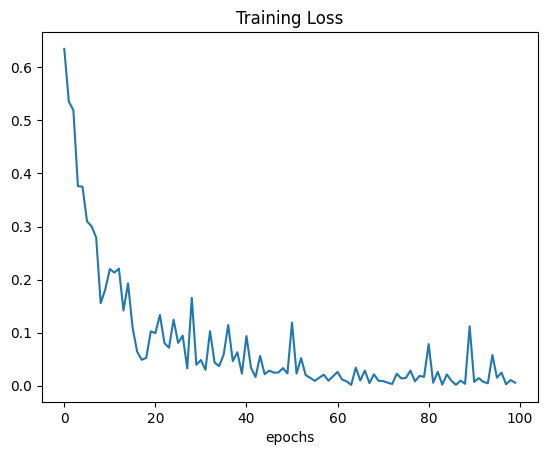

In [33]:
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("epochs")
plt.show()

# Test per la bayesian network.
Each test example has to be infered with the bayesian network k times.

I get at the end a matrix having as raws the number of test examples and as columns the number of times the bayesian network has to be infered.

For the i-th test example, each column is a aleatory variable that rapresent the value of prediction for that example.

I have to obtain the density probability for raw , so i can know how many is probable a certain prediction.

At the end for each example the real prediction is the most probable value, so the value that has the highest density probability.


In [40]:
# test per fare
from torch.utils.data import DataLoader

model = BayesianNN()
model.load_state_dict(torch.load('modello_bayesiano.pth'))

print(model)

iteration = 100
#per ogni iterazione avroò una predizione per ogni test example (20 per ogni colonna della matrice pred_tot)
pred_tot = torch.zeros(len(test_loader.dataset), iteration) 
# infers the test set
for k in range(iteration):
    # print(pred_tot)
    #tensore con 20 colonne e tante righe quanto il range di iterazioni (100 in questo caso)
    
    # print(pred_tot.shape)
    with torch.no_grad():
        for x, y in test_loader:
            y_test_pred = model(x)
            print(y_test_pred)
            print(y_test_pred.shape)
            # print(y_test_pred.shape)
            #salva le predizioni per ogni batch come una colonna di un tensore
            #le righe saranno la distribuzione di probabilità per ogni test example 
        pred_tot[:,k] = y_test_pred[:,0]
        print(pred_tot.shape)
# print(pred_tot)


    

       

BayesianNN(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=300, bias=True)
    (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=300, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
tensor([[1.6398e-01],
        [1.3030e-01],
        [2.2081e-01],
        [5.0632e-01],
        [2.8014e-01],
        [9.2614e-01],
        [9.9844e-01],
        [9.2708e-01],
        [2.5815e-01],
        [2.7598e-05],
        [3.4885e-01],
        [9.6224e-01],
        [1.5148e-02],
        [9.9998e-01],
        [3.5273e-02],
        [8.5202e-01],
        [5.9392e-01],
        [5.2078e-05],
        [1.4322e-03],
        [9.9980e-01]])
torch.Size([20, 1])
torch.

In [36]:
pred_tot = pred_tot.numpy()

In [39]:
pred_tot.shape

torch.Size([20, 100])

In [37]:
pred_tot.shape[0]

20

da capire ancora come estrarre la ddp di ogni riga della matrice per ottenere il valore di y_pred con la massima probabilità.

# funzione per ottenere la ddp di ogni riga della matrice scipy.stats.norm

In [41]:
import scipy.stats as st
